<a href="https://colab.research.google.com/github/MucaCirone/Master_Thesis/blob/main/rSigKer_convergence_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows some empirical convergence results concerning Randomized Signature Kernels as discussed in my master's thesis.

# Importing Libraries

In [ ]:
!pip install git+https://github.com/patrick-kidger/torchcde.git
!pip install git+https://github.com/crispitagorico/sigkernel.git

In [2]:
import numpy as np
from tqdm import tqdm
import torch
import torchcde
import sigkernel
import matplotlib.pyplot as plt

import seaborn as sns
import scipy
import sklearn.metrics as metrics

sns.set_context('notebook')

# rSig Euler 

In this section I define functions which compute the randomized signature kernel with linear driving dynamics i.e.

$$rSig(\omega)_t = ∑_{i=0}^d [A_i \cdot rSig(\omega)_t + b_i] d\omega_t^i $$

where $\omega \in BV_c([0,1];\mathbb{R}^d)$ is the control.

In [3]:
def rSig_Euler(data_x, hidden_dim, bias=True, initial=True):
  # Compute rSignature
    
    batch_x, timesteps_x, input_dim = data_x.shape
    # Compute differences
    dx = np.diff(data_x, axis = 1) 

    # Build VFields
    if initial:
        S0 =  (1/np.sqrt(hidden_dim))*np.random.randn(hidden_dim)
    else:
        S0 = (1/np.sqrt(hidden_dim))*np.ones(hidden_dim)
    
    As = (1/np.sqrt(hidden_dim))*np.random.randn(input_dim, hidden_dim, hidden_dim)

    if bias:
        bs = (1/np.sqrt(hidden_dim))*np.random.randn(input_dim, hidden_dim)
    else: 
        bs = np.zeros((input_dim, hidden_dim))

    rSigs_x = np.zeros((batch_x, hidden_dim))
    rSigs_x[:,:] = S0

    # Compute rSigs
    for control in range(batch_x):
        for t in range(timesteps_x - 1):
            dZ_x = np.sum([((As[i,:,:]@rSigs_x[control,:]) + bs[i,:])*dx[control, t, i] for i in range(input_dim)],0)
            rSigs_x[control,:] += dZ_x

    return rSigs_x

In [4]:
def rSigKer_Euler(data_x, data_y, hidden_dim, MC_iter, same = False, bias=True, initial=True):
    """
    Compute the rSigKernel on a batch of input pairs (x_i,y_i)
    
    data_x : (batch_x, timesteps_x, input_dim_x) Numpy array
    data_y : (batch_x, timesteps_y, input_dim_y) Numpy array
    """

    batch_x, timesteps_x, input_dim = data_x.shape
    batch_y, timesteps_y, input_dim_y = data_y.shape

    assert input_dim == input_dim_y
    assert batch_x == batch_y

    # Compute differences
    dx = np.diff(data_x, axis = 1) 
    if not same: dy = np.diff(data_y, axis = 1) 

    prod_final = np.zeros(batch_x)

    for iter in tqdm(range(MC_iter)):

        # Build VFields
        if initial:
            S0 =  (1/np.sqrt(hidden_dim))*np.random.randn(hidden_dim)
        else:
            S0 = (1/np.sqrt(hidden_dim))*np.ones(hidden_dim)

        As = (1/np.sqrt(hidden_dim))*np.random.randn(input_dim, hidden_dim, hidden_dim)

        if bias:
            bs = (1/np.sqrt(hidden_dim))*np.random.randn(input_dim, hidden_dim)
        else: 
            bs = np.zeros((input_dim, hidden_dim))

        # Set initial values as z0
        rSigs_x = np.zeros((batch_x, hidden_dim))
        rSigs_x[:,:] = S0
        if not same: 
            rSigs_y = np.zeros((batch_y, hidden_dim))
            rSigs_y[:,:] = S0
          
        def sigmoid(x): return x #np.tanh(x) #1 / (1 + np.exp(-x))

        # Compute rSigs
        for control in range(batch_x):
            for t in range(timesteps_x - 1):
                dZ_x = np.sum([sigmoid(((As[i,:,:]@rSigs_x[control,:]) + bs[i,:]))*dx[control, t, i] for i in range(input_dim)],0)
                rSigs_x[control,:] += dZ_x
          
        if not same:
            for control in range(batch_x):
                for t in range(timesteps_x - 1):
                    dZ_y = np.sum([sigmoid(((As[i,:,:]@rSigs_y[control,:]) + bs[i,:]))*dy[control, t, i] for i in range(input_dim)],0)
                    rSigs_y[control,:] += dZ_y

        # Compute Products
        prods = np.zeros(batch_x)

        if same: rSigs_y = rSigs_x

        for i in range(batch_x):
          prods[i] = rSigs_y[i].dot(rSigs_x[i])

        prod_final += prods

    prod_final = (1/MC_iter)*prod_final
    return prod_final

# Data

Cration of the datasets. All the credit goes to Maud Lemercier (https://warwick.ac.uk/fac/sci/statistics/staff/research_students/mlemercier).

In [5]:
def exponentiated_quadratic(xa, xb, sigma):
    """
    Exponentiated quadratic  with σ = 1
    i.e. exp ( - 1/2\sigma * [squared euclidean distance matrix of elements in xa and xb])
    """
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm/sigma)

In [6]:
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx)) 
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).to(a.device)
    return torch.index_select(a, dim, order_index)

In [7]:
# Synthetic data
batch, len_x, len_y = 400, 10, 10

# Independent variable samples
U = np.expand_dims(np.linspace(-2, 2, len_x), 1)
Sigma = exponentiated_quadratic(U, U, sigma=.25)  # Kernel of data points 

# Draw samples 
y1 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
y2 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
y3 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
x1 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
x2 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
x3 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)

x = .15*np.stack([x1,x2,x3],axis=2)
y = .15*np.stack([y1,y2,y3],axis=2)

# x.shape  -- (400, 10, 3)

In [8]:
# batch  - Number of controls
k = 500  # Reservoir Dimension
d = 3    # Control Dimension
n = 4    # Tiling parameter
M = 1    # MC iterations


dx = np.diff(x, axis=1)
dy = np.diff(y, axis=1)

# tile the signals
dx = (1./(2**n))*tile(torch.tensor(dx), 1, 2 ** n).numpy()
dy = (1./(2**n))*tile(torch.tensor(dy), 1, 2 ** n).numpy()


T = dx.shape[1] # Timesteps

# SigKer - computation


In [9]:
# Specify the static kernel (for linear kernel use sigkernel.LinearKernel())
static_kernel = sigkernel.LinearKernel()

# Specify dyadic order for PDE solver (int > 0, default 0, the higher the more accurate but slower)
dyadic_order = 4

# Initialize the corresponding signature kernel
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

# Compute signature kernel "batch-wise" (i.e. k(x_1,y_1),...,k(x_batch, y_batch))
sk = signature_kernel.compute_kernel(torch.tensor(x), torch.tensor(y))

# rSig - computation

Without Bias

In [10]:
truncation = 100
new_x = np.append(np.zeros((dx.shape[0],1,dx.shape[2])),np.cumsum(dx, axis =1), axis = 1)
new_y = np.append(np.zeros((dy.shape[0],1,dy.shape[2])),np.cumsum(dy, axis =1), axis = 1)
new_prods = rSigKer_Euler(new_x[:truncation],new_y[:truncation],1000,20, bias = False)
new_prods_ = new_prods

100%|██████████| 20/20 [08:50<00:00, 26.53s/it]


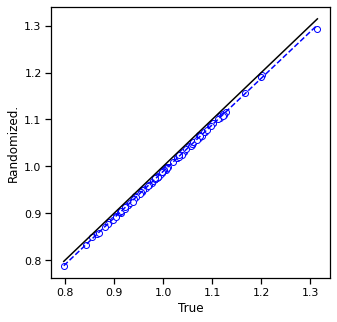

R2: 0.9831571482024842


In [11]:
new_sk = sk[:truncation]
#new_prods = 0.5*(new_prods + 1)

plt.figure(figsize=(5,5))
plt.scatter(new_sk, new_prods, edgecolors='blue', color='white')
plt.plot(np.unique(new_sk), np.poly1d(np.polyfit(new_sk, new_prods, 1))(np.unique(new_sk)), color='blue', ls='--')
plt.plot(np.unique(new_sk), np.unique(new_sk),'k-')
plt.xlabel('True')
plt.ylabel('Randomized.')
plt.show()
print('R2:', metrics.r2_score(new_sk, new_prods))

With Bias

In [16]:
truncation = 100
new_x = np.append(np.zeros((dx.shape[0],1,dx.shape[2])),np.cumsum(dx, axis =1), axis = 1)
new_y = np.append(np.zeros((dy.shape[0],1,dy.shape[2])),np.cumsum(dy, axis =1), axis = 1)
new_prods = rSigKer_Euler(new_x[:truncation],new_y[:truncation],1000,20, bias = True)
new_prods_ = new_prods

100%|██████████| 20/20 [07:53<00:00, 23.65s/it]


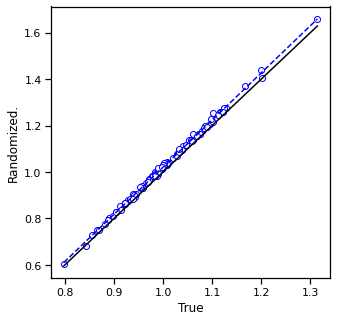

R2: 0.9823141713259618


In [18]:
new_sk = sk[:truncation]
#new_prods = 0.5*(new_prods + 1)

plt.figure(figsize=(5,5))
plt.scatter(new_sk, new_prods, edgecolors='blue', color='white')
plt.plot(np.unique(new_sk), np.poly1d(np.polyfit(new_sk, new_prods, 1))(np.unique(new_sk)), color='blue', ls='--')
plt.plot(np.unique(new_sk), 2*np.unique(new_sk)-1,'k-')
plt.xlabel('True')
plt.ylabel('Randomized.')
plt.show()
print('R2:', metrics.r2_score(2*new_sk-1, new_prods))

# Comments

There is still lots of work to do to optimize the computations, the next objective is that of using the TorchCDE framework to write a fast implementation.